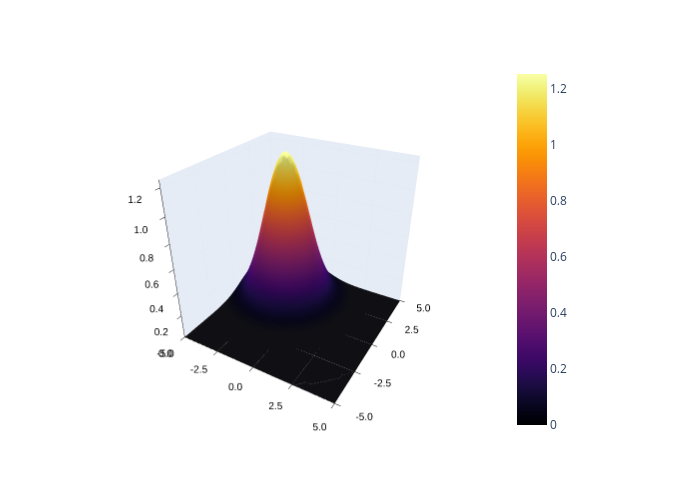

In [53]:
using Plots; plotlyjs()
using LinearAlgebra
using SymPy
using BenchmarkTools

q, q0, q1, q2, qf = symbols("q q_0 q_1 q_2 q_F", real = true)
m, t, t0, t1, t2, tf = symbols("m t t_0 t_1 t_2 t_F", real = true, positive = true)
q0p, q1p, q2p, qfp = symbols("q^{\\prime}_0 q^{\\prime}_1 q^{\\prime}_2 q^{\\prime}_F", real = true)
a, b, c, d, e, f = symbols("a b c d e f")
s1, s2, p1, p2, σ1, σ2 = symbols("s_1 s_2 p_1 p_2 σ_1 σ_2")

freePropagator(finPos, startPos, finTime, startTime = 0, m = 1) = sqrt(m / (2 * pi * im * (finTime - startTime))) * exp(im * m / (2 * (finTime - startTime)) * (finPos - startPos)^2)  
freePropagatorC(qf, qfp, q0, q0p, tf, t0) = freePropagator(qf, q0, tf, t0) + freePropagator(qfp, q0p, tf, t0)

initStateFunction(q0, q0p, σ1, s1, p1, σ2, s2, p2) = (1//2 * pi * σ1)^(1//4) * exp(-(q0 - s1)^2 / (4 * σ1^2) + im * p1 * q0) * (1//2 * pi * σ2)^(1//4) * exp(-(q0p - s2)^2 / (4 * σ2^2) + im * p2 * q0p)

maxPos = 5
minPos = -5
stepPos = 0.25

pos1Vect = collect(minPos:stepPos:maxPos)
pos2Vect = collect(minPos:stepPos:maxPos)
posVectSize = size(pos1Vect, 1)
posMat = [(i, j) for i in pos1Vect, j in pos2Vect]

posToIndex(pos) = Int32((pos - minPos) / stepPos  + 1)

initState(q) = initStateFunction(q[1], q[2], 1, 2, 2, 1, -2, -2)
initMat = initState.(posMat)
initMat = round.(initMat, digits = 7)

surface(pos1Vect, pos2Vect, abs.(initMat))

In [64]:
finalTime = 1
finalMat = Matrix{ComplexF32}(undef, posVectSize, posVectSize)

for xf in pos1Vect, xfp in pos2Vect
    sumPos = 0
    for i in 1:posVectSize, j in 1:posVectSize
        x0 = pos1Vect[i]
        x0p = pos2Vect[j]
        sumPos += freePropagatorC(xf, xfp, x0, x0p, finalTime, 0) * initMat[i, j]
    end
    finalMat[posToIndex(xf), posToIndex(xfp)] = sumPos
end

surface(pos1Vect, pos2Vect, abs2.(finalMat))